In [1]:
from Padd.models import PowerPaintControlNet
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import torch
import numpy as np
from diffusers.utils import load_image
import diffusers

%load_ext autoreload
%autoreload 2

/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


### Necessory functions

In [12]:
def GetMaskedImage(image, mask):
    mask_np = np.array(mask.convert("RGB"))

    red = np.array(image).astype("float") * 1
    red[:, :, 0] = 180.0
    red[:, :, 2] = 0
    red[:, :, 1] = 0
    result_m = np.array(image)
    result_m = Image.fromarray(
        (result_m.astype("float") * (1 - mask_np.astype("float") / 512.0)
        + mask_np.astype("float") / 512.0 * red
        ).astype("uint8"))
    return result_m

def CombineImagesHorizontally(*images):
    if not images:
        raise ValueError("No images provided")

    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    combined_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_image

### Look at the data

In [128]:
image = Image.open("examples/image.jpg")
cat_mask = Image.open("examples/cat_mask.jpg")
person_mask = Image.open("examples/person_mask.png")

image_landscape = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")

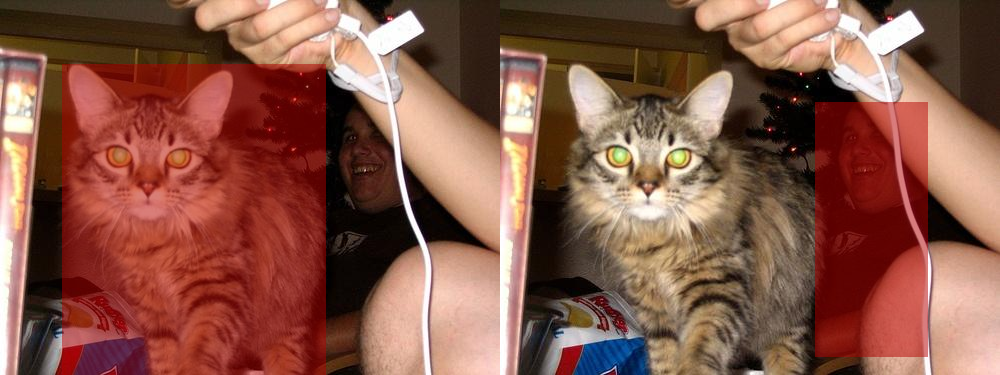

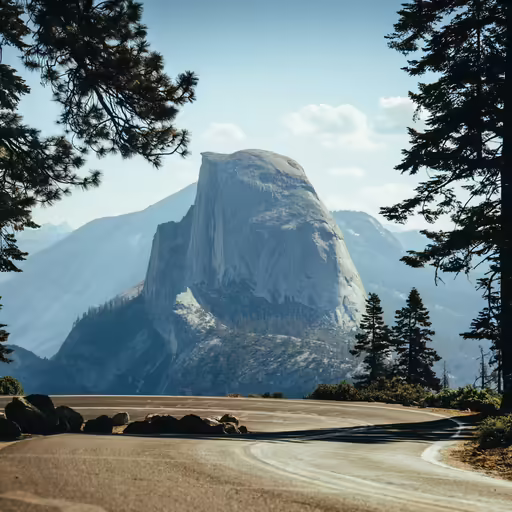

In [131]:
CombineImagesHorizontally(GetMaskedImage(image, cat_mask), GetMaskedImage(image, person_mask)).show()
image_landscape.show()

### Depth extraction

In [22]:
def get_depth_map(image, ImageProcessor, ModelForDepthEstimation):
        image = ImageProcessor(images=image, return_tensors="pt").pixel_values.to("cuda")
        with torch.no_grad(), torch.autocast("cuda"):
            depth_map = ModelForDepthEstimation(image).predicted_depth

        depth_map = torch.nn.functional.interpolate(
            depth_map.unsqueeze(1),
            size=(1024, 1024),
            mode="bicubic",
            align_corners=False,
        )
        depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
        depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
        depth_map = (depth_map - depth_min) / (depth_max - depth_min)
        image = torch.cat([depth_map] * 3, dim=1)

        image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
        image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
        return image

#### Depth-Anything

In [7]:
ImageProcessor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
DepthAnything = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf").to("cuda")

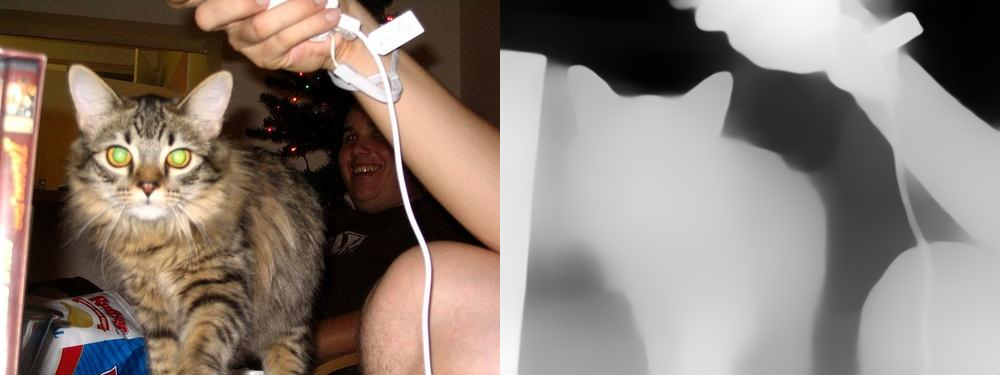

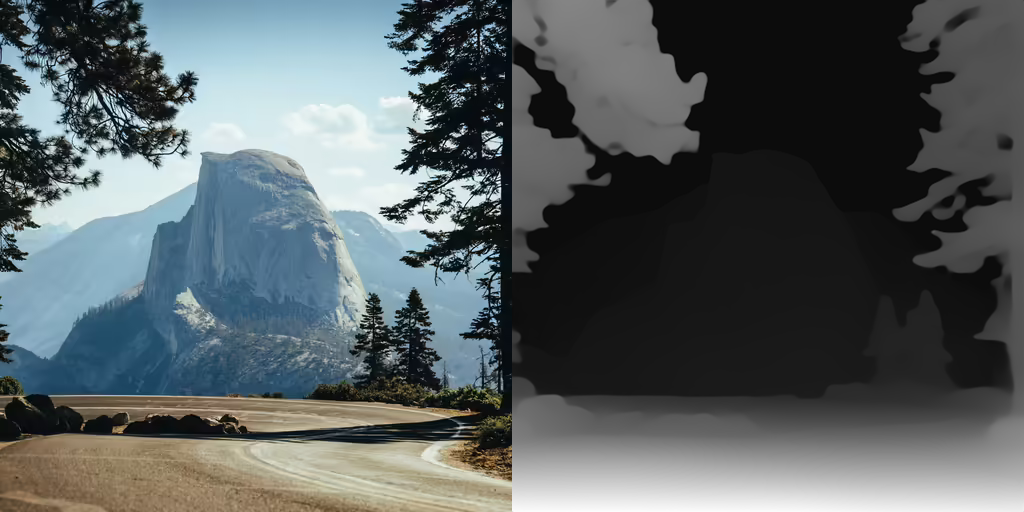

In [12]:
CombineImagesHorizontally(image, 
                          get_depth_map(image, ImageProcessor, DepthAnything).resize(image.size)).show()

CombineImagesHorizontally(image_landscape, 
                          get_depth_map(image_landscape, ImageProcessor, DepthAnything).resize(image_landscape.size)).show()

#### Depth-Anything v2

In [23]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

ImageProcessor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
DepthAnythingv2 = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to("cuda")

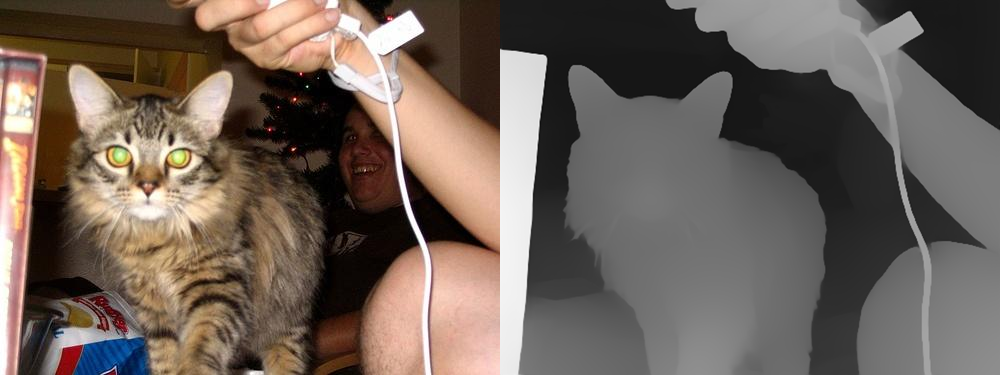

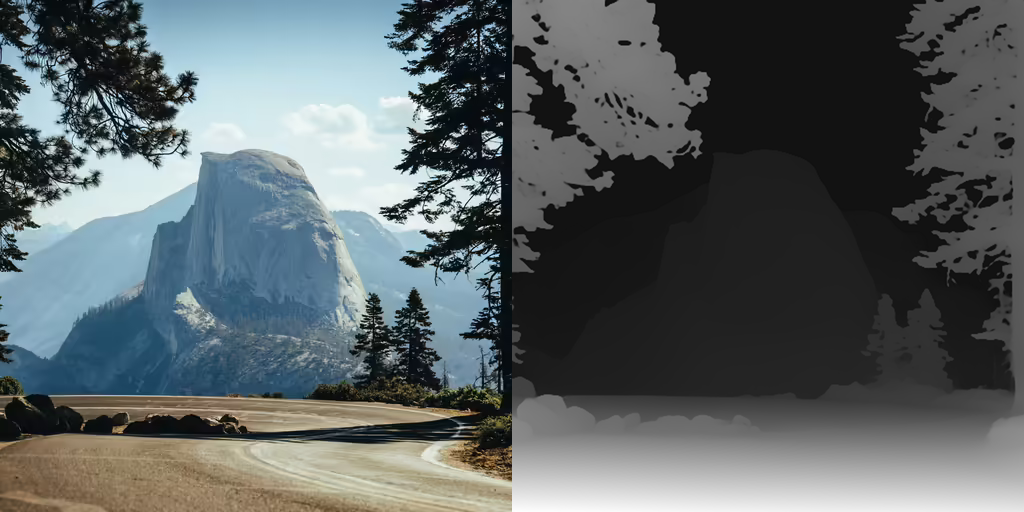

In [14]:
CombineImagesHorizontally(image, 
                          get_depth_map(image, ImageProcessor, DepthAnythingv2).resize(image.size)).show()

CombineImagesHorizontally(image_landscape, 
                          get_depth_map(image_landscape, ImageProcessor, DepthAnythingv2).resize(image_landscape.size)).show()

#### Marigold

In [73]:
pipe = diffusers.MarigoldDepthPipeline.from_pretrained(
    "prs-eth/marigold-depth-lcm-v1-0", prediction_type="depth", variant="fp16", torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Marigold predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Diffusion steps...:   0%|          | 0/1 [00:00<?, ?it/s]

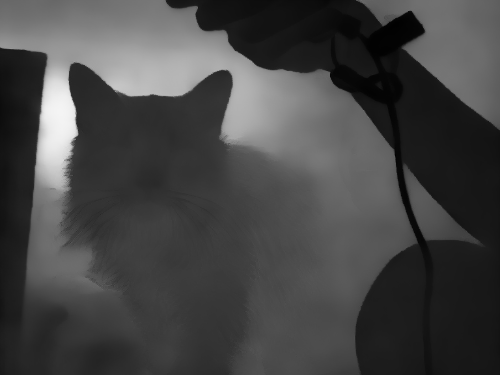

In [74]:
image = Image.open("examples/image.jpg")
depth_map = pipe(image)
depth_16bit = pipe.image_processor.export_depth_to_16bit_png(depth_map.prediction)
depth_16bit[0]

Marigold predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Diffusion steps...:   0%|          | 0/1 [00:00<?, ?it/s]

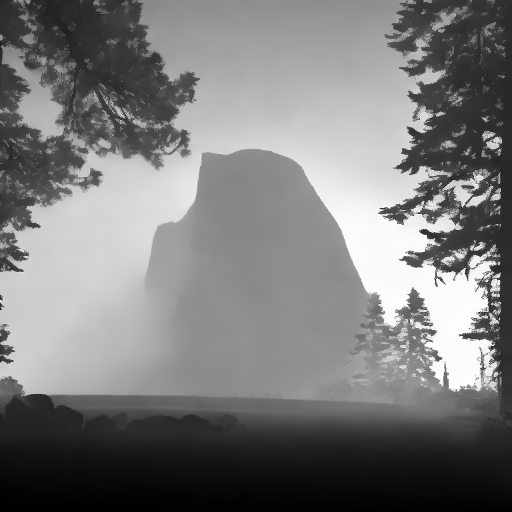

In [75]:
image_landscape = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
depth_map = pipe(image_landscape)
depth_16bit = pipe.image_processor.export_depth_to_16bit_png(depth_map.prediction)
depth_16bit[0]

### PowerPaint with ControlNet

In [95]:
model = PowerPaintControlNet()

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae: Error no file named diffusion_pytorch_model.safeten

09/09 16:31:33 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
09/09 16:31:33 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/open_pose/body.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer

In [9]:
img = {"image": image, "mask": cat_mask}

In [10]:
new_image, controlnet_image = model(
        input_image=img,
        input_control_image=image,
        control_type="depth",
        prompt="white dog",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8)

  0%|          | 0/50 [00:00<?, ?it/s]

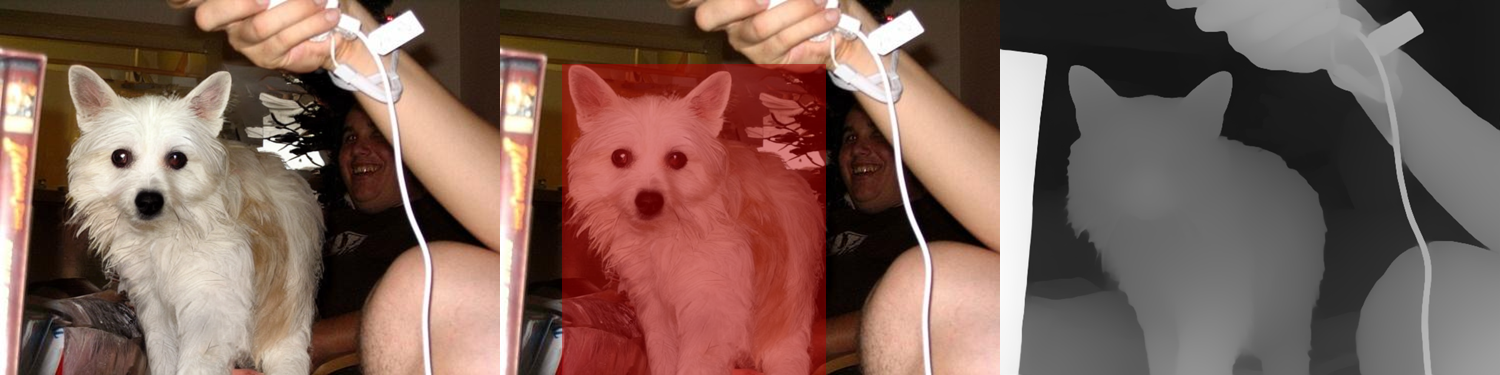

In [13]:
CombineImagesHorizontally(new_image, GetMaskedImage(new_image, cat_mask), controlnet_image)

In [101]:
img = {"image": image, "mask": person_mask}

In [103]:
new_image, controlnet_image = model(
        input_image=img,
        input_control_image=image,
        control_type="depth",
        prompt="women",
        ddim_steps=50,
        scale=5,
        seed=2,
        controlnet_conditioning_scale=0.8)

  0%|          | 0/50 [00:00<?, ?it/s]

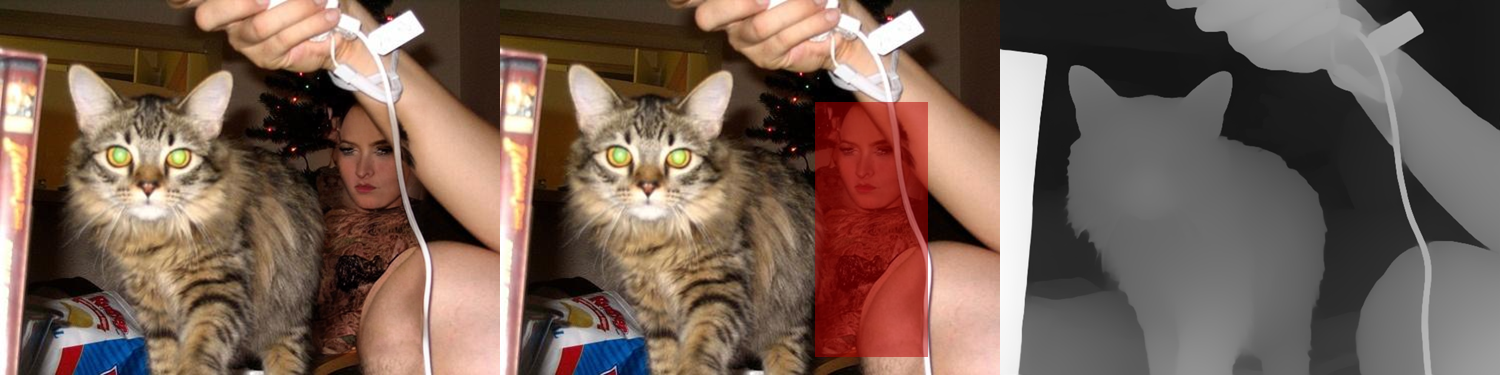

In [104]:
CombineImagesHorizontally(new_image, GetMaskedImage(new_image, person_mask), controlnet_image)

### Add new object

In [134]:
# load base and mask image
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
cat_image = load_image("https://avatars.mds.yandex.net/i?id=19db7f313270e86fed5cb2a10547dcd5_l-5087196-images-thumbs&n=13")

#### Getting mask with SAM

In [137]:
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

raw_image = cat_image
input_points = [[[1000, 600]]]  # 2D location of a window in the image

inputs = sam_processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    model.eval()
    outputs = model(**inputs)

masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

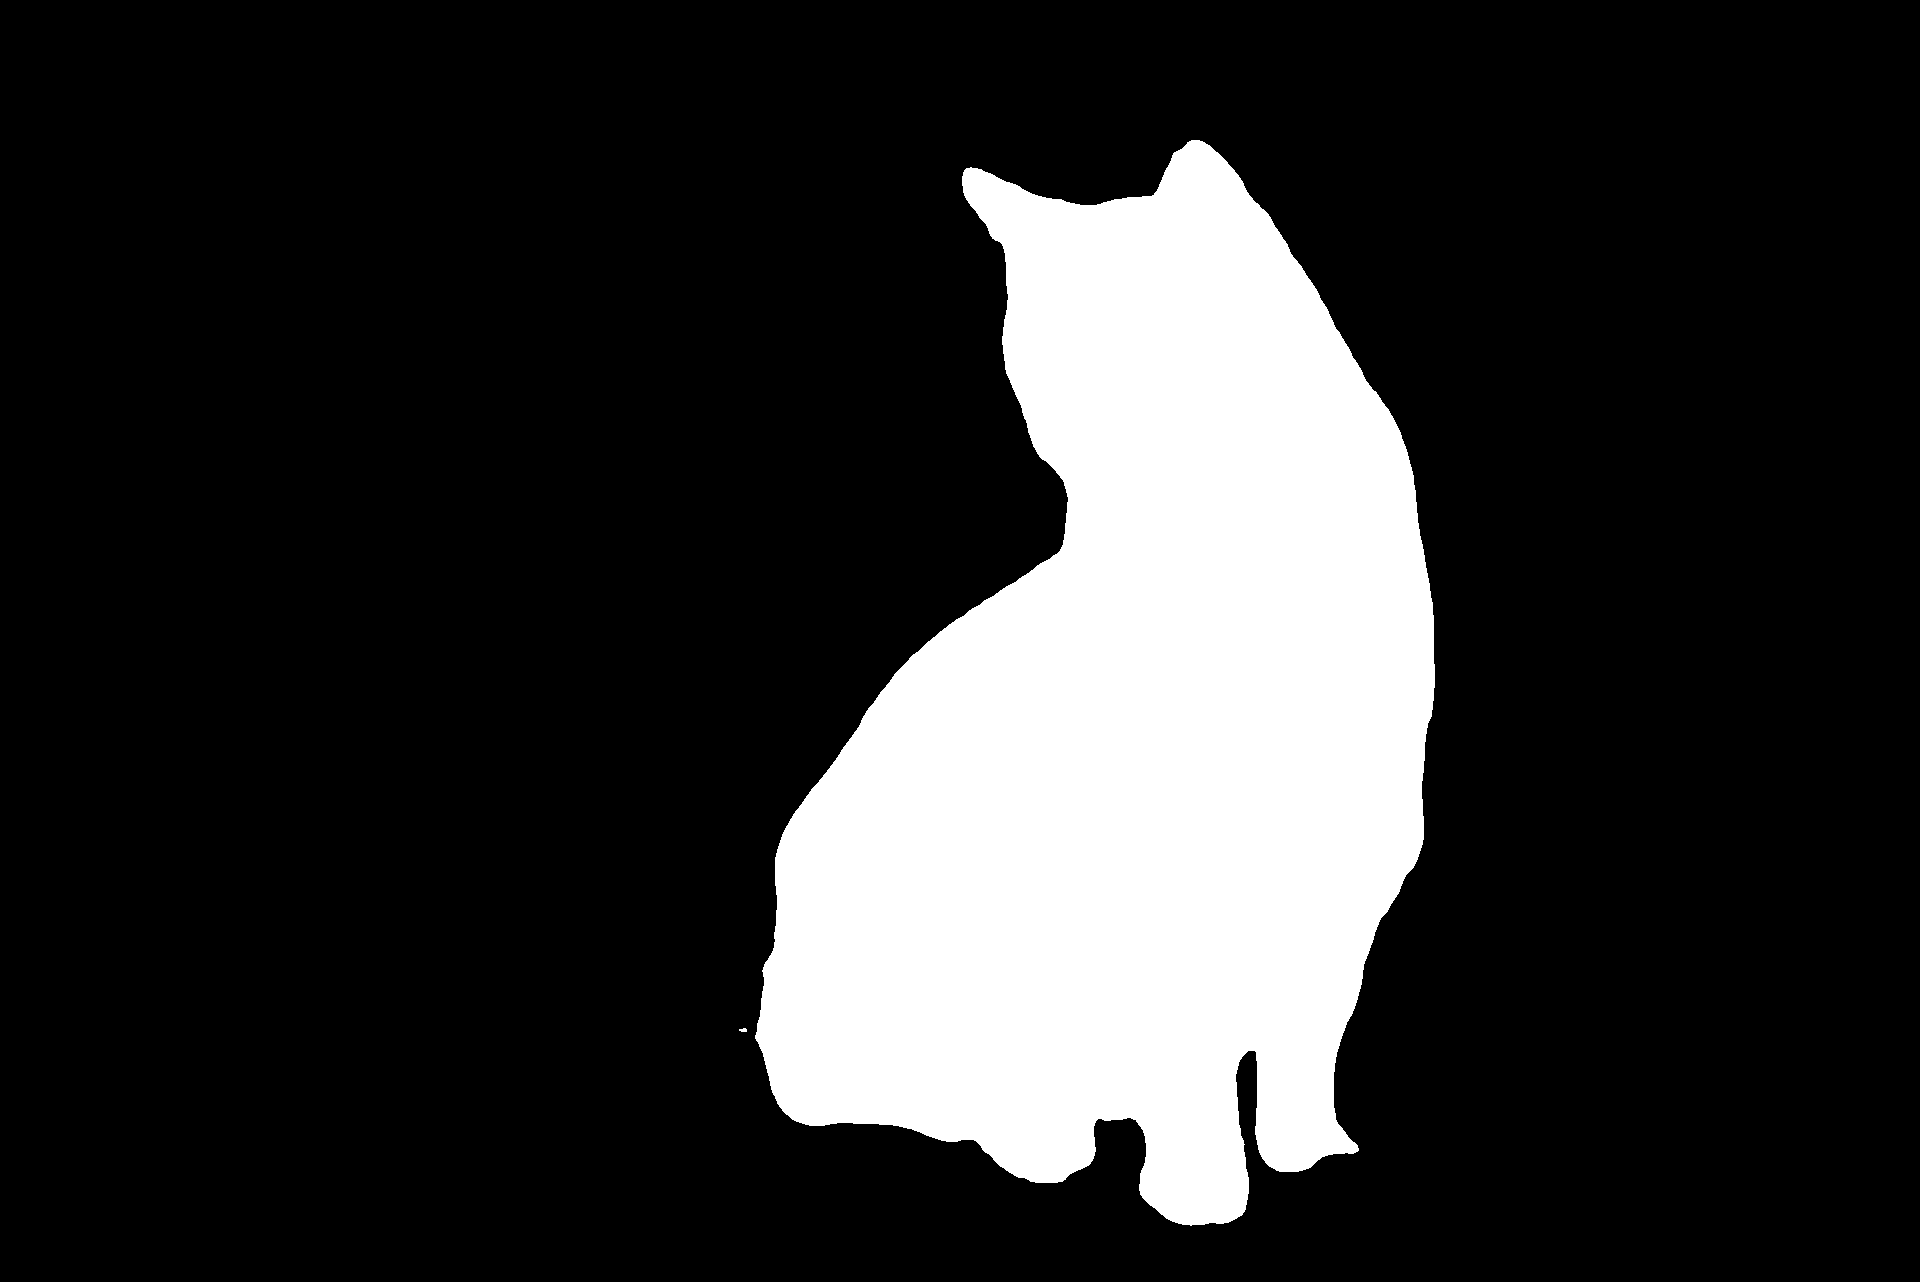

In [138]:
cat_mask = Image.fromarray(masks[0][0][1].numpy().astype(np.uint8) * 255)
cat_mask

#### Processing depth images

In [139]:
cat_depth_image = get_depth_map(cat_image, ImageProcessor, DepthAnythingv2).resize(cat_image.size)
scene_depth_image = get_depth_map(image, ImageProcessor, DepthAnythingv2).resize(image.size)

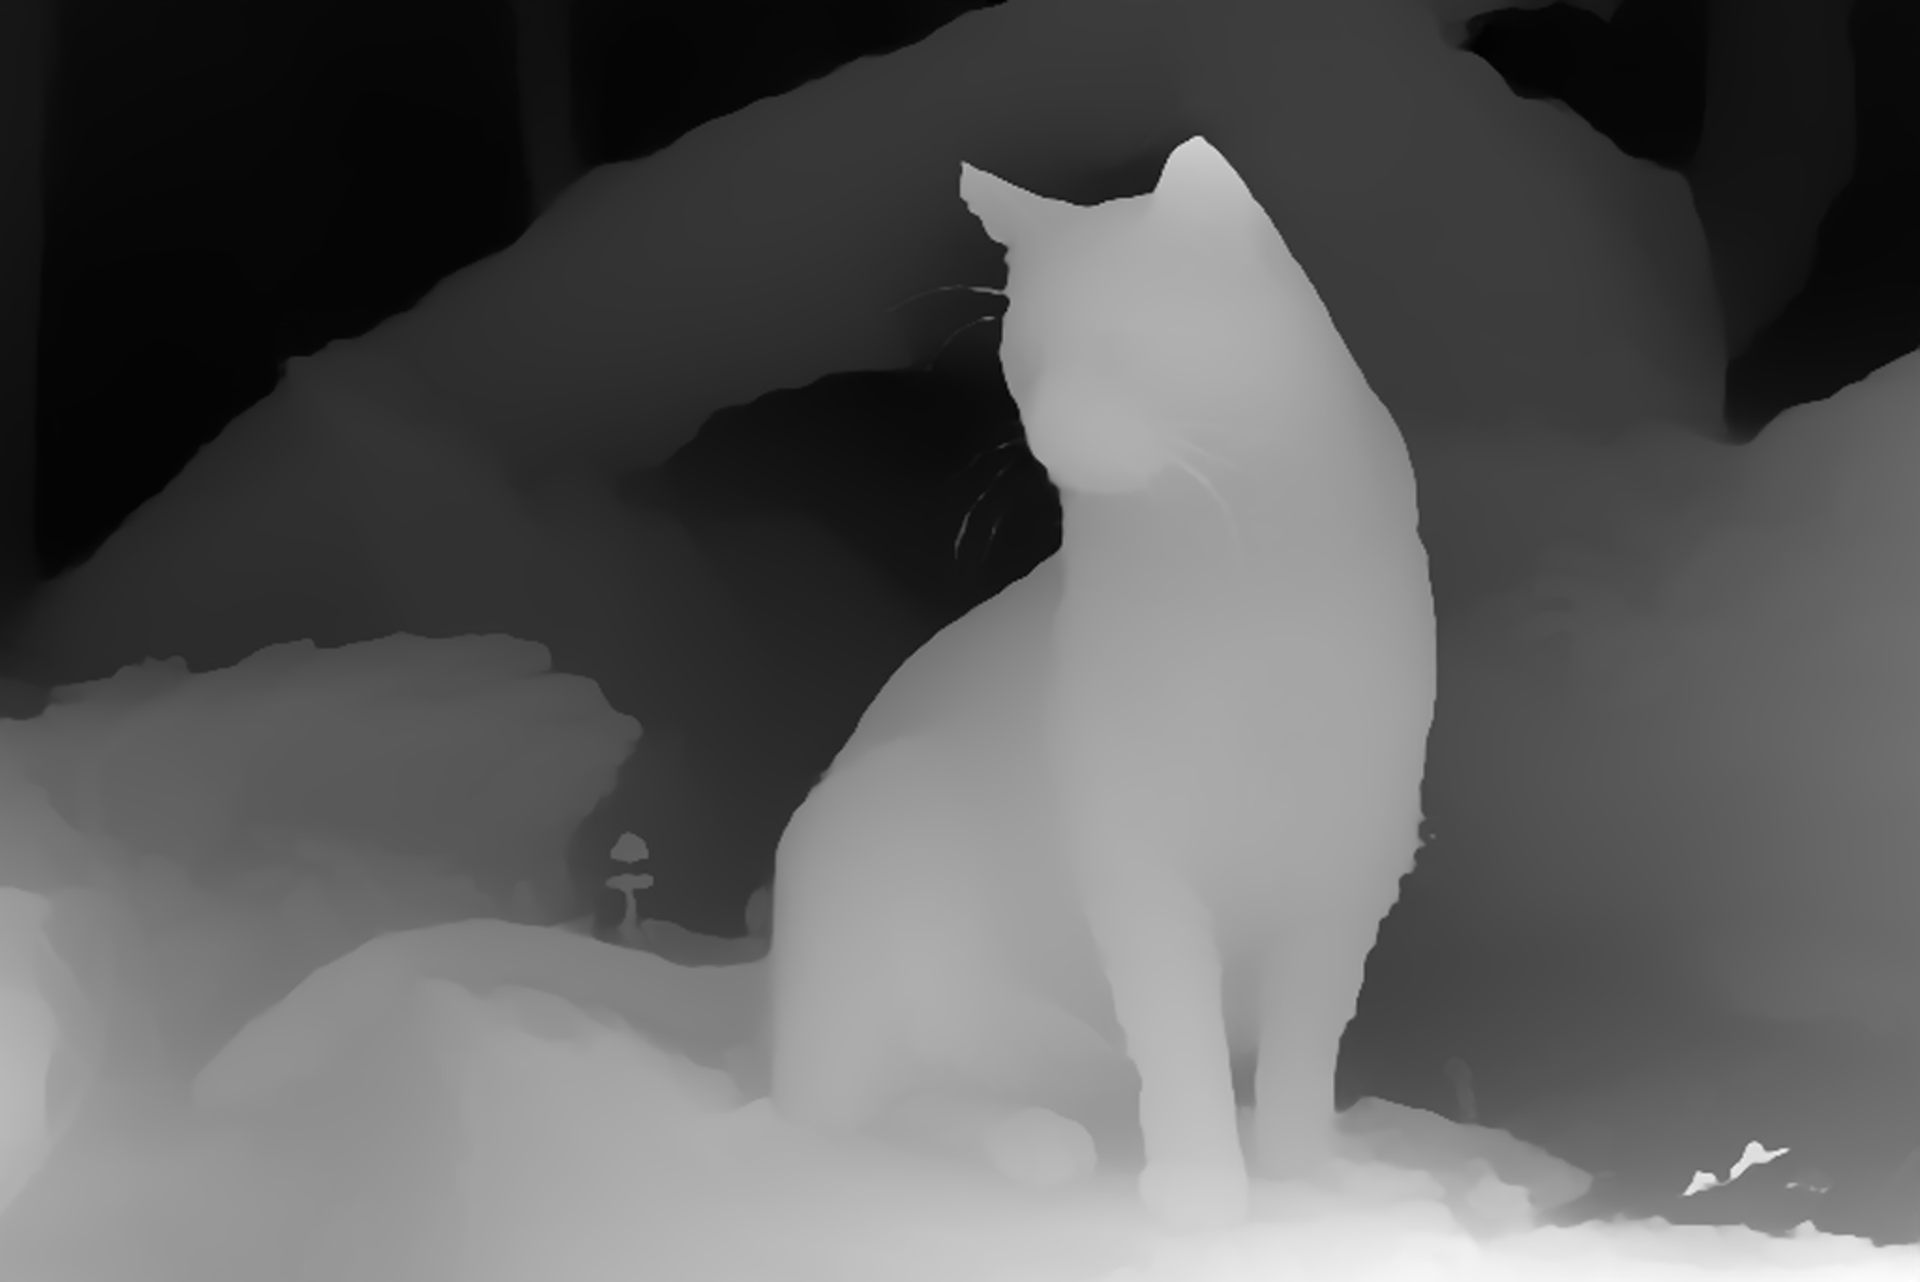

In [141]:
cat_depth_image

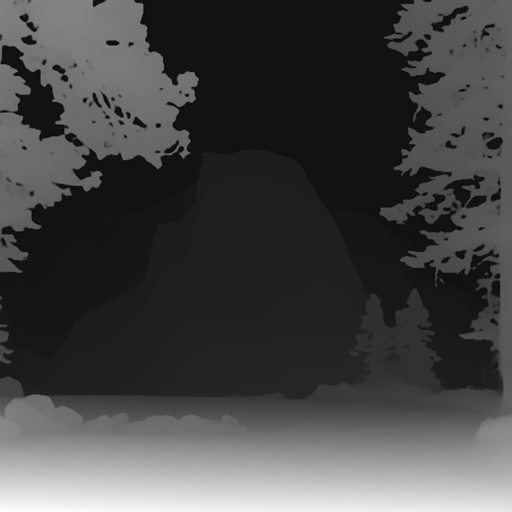

In [140]:
scene_depth_image

In [142]:
from PIL import Image, ImageOps
import random

def resize_and_random_flip(image, mask):
    # Randomly select a resizing factor between 0.5 and 2.0
    factor = random.uniform(0.5, 2.0)

    # Calculate the new size
    new_size = (int(image.width * factor), int(image.height * factor))

    # Resize the images
    resized_image = image.resize(new_size)
    resized_mask = mask.resize(new_size)

    # Randomly flip the images
    if random.choice([True, False]):
        resized_image = ImageOps.mirror(resized_image)
        resized_mask = ImageOps.mirror(resized_mask)

    return resized_image, resized_mask

In [143]:
size = (400, 302)
small_image = cat_depth_image.resize(size)
small_mask_image = cat_mask.convert('L').resize(small_image.size)

resized_cat_image, resized_cat_mask = resize_and_random_flip(small_image, small_mask_image)

In [144]:
add_value = -40
resized_cat_image = Image.eval(resized_cat_image, lambda x: x - add_value)

In [145]:
def crop_mask(mask_image):
    coords = np.argwhere(mask_image)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Crop the image using the bounding box
    cropped_image = mask_image.crop((x_min, y_min, x_max + 1, y_max + 1))
    return cropped_image

cropped_cat_image = crop_mask(resized_cat_mask)


In [146]:
import cv2

def calculate_average_depth_and_bottom_point(depth_map, mask):
    # Ensure both inputs are numpy arrays
    depth_map = np.array(depth_map)
    mask = np.array(mask)
    
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)
    if len(depth_map.shape) == 3:
        depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2GRAY)
    # Apply mask to depth map
    masked_depth = depth_map * mask
    
    # Calculate average depth of non-zero (masked) pixels
    total_depth = np.sum(masked_depth)
    num_pixels = np.sum(mask)
    
    if num_pixels > 0:
        average_depth = total_depth / num_pixels
    else:
        average_depth = 0
    
    # Find the bottom point (lowest non-zero pixel in the mask)
    bottom_point = None
    non_zero_indices = np.argwhere(mask)
    if non_zero_indices.size > 0:
        bottom_point = non_zero_indices[-1]
    
    return average_depth, bottom_point

# Example usage:
average_depth, bottom_point = calculate_average_depth_and_bottom_point(resized_cat_image, resized_cat_mask)

In [147]:
import numpy as np

def sample_random_coordinates(array, num_samples=1):
    # Find indices where the value is 1
    indices = np.argwhere(array == 1)
    
    # If num_samples is greater than available indices, adjust the sample size
    num_samples = min(num_samples, len(indices))
    
    # Randomly sample the indices
    sampled_indices = indices[np.random.choice(len(indices), num_samples, replace=False)]
    
    # Return the sampled coordinates as a list of tuples
    return [tuple(coord) for coord in sampled_indices]

# Sample one random coordinate where the value is 1
location_array = (np.array(scene_depth_image) > 195).astype(float)
sampled_coords = sample_random_coordinates(location_array, num_samples=1)
print(np.array(sampled_coords[0])[:2])

[493 112]


In [148]:
object_point = bottom_point
scene_point = np.array(sampled_coords[0])[:2]
paste_x = (scene_point[0] - object_point[0])
paste_y = (scene_point[1] - object_point[1])
position = (paste_y, paste_x)

In [149]:
import copy
def blend_condition_images(large_image, small_image, small_mask_image, position):
    large_image = copy.copy(large_image)

    # Define the position where the small image will be placed (e.g., bottom-right corner)
    position_test = (large_image.width - small_image.width, large_image.height - small_image.height)
    # print(position_test)
    # print(position)
    # Paste the small image onto the large image at the defined position
    large_image.paste(small_image, position, small_mask_image)
    
    # Save or display the final image
    return large_image

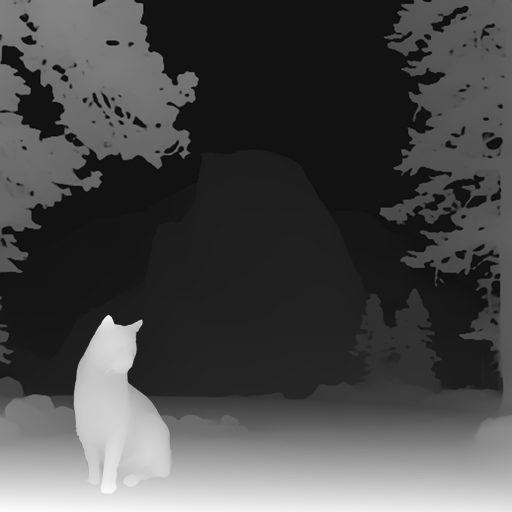

In [150]:
large_image = blend_condition_images(scene_depth_image, resized_cat_image, resized_cat_mask, position)
large_image

In [155]:
blended_mask = Image.new("L", image.size, 0)

# Paste the small image onto the large image at the defined position
blended_mask.paste(resized_cat_mask, position)

In [156]:
model = PowerPaintControlNet()

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae: Error no file named diffusion_pytorch_model.safeten

09/09 17:01:43 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
09/09 17:01:43 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/open_pose/body.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer

  0%|          | 0/50 [00:00<?, ?it/s]

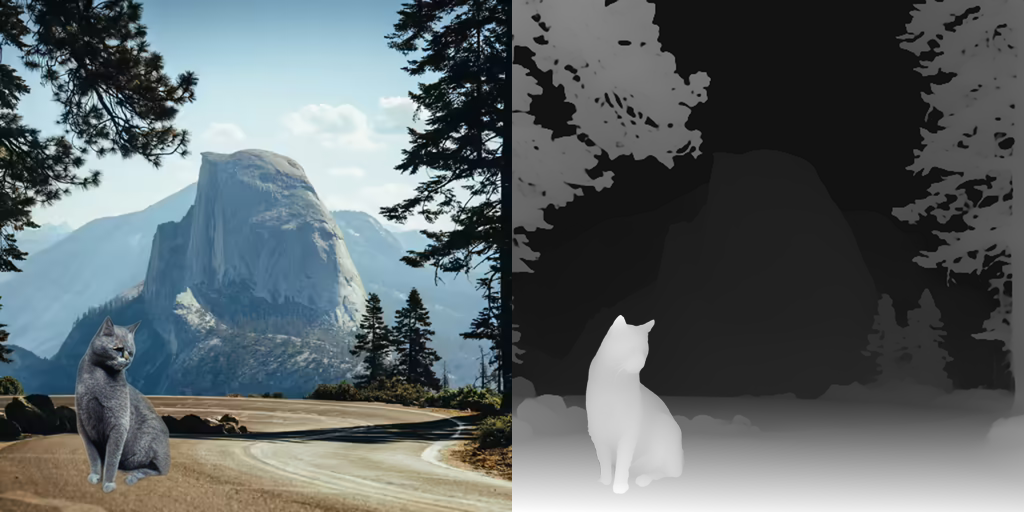

In [157]:
img = {"image": image, "mask": blended_mask}

new_image, controlnet_image = model(
        input_image=img,
        input_control_image=large_image,
        control_type="depth",
        prompt="Grey cat",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8,
        get_depth_map=False)

CombineImagesHorizontally(new_image, large_image)

  0%|          | 0/50 [00:00<?, ?it/s]

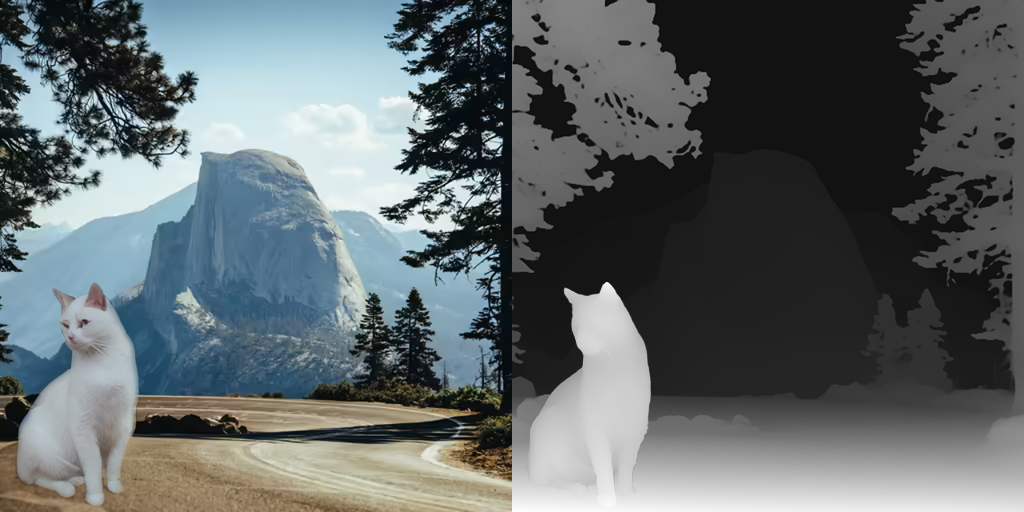

In [125]:
img = {"image": image, "mask": blended_mask}

new_image, controlnet_image = model(
        input_image=img,
        input_control_image=large_image,
        control_type="depth",
        prompt="white cat",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8,
        get_depth_map=False)

CombineImagesHorizontally(new_image, large_image)

  0%|          | 0/50 [00:00<?, ?it/s]

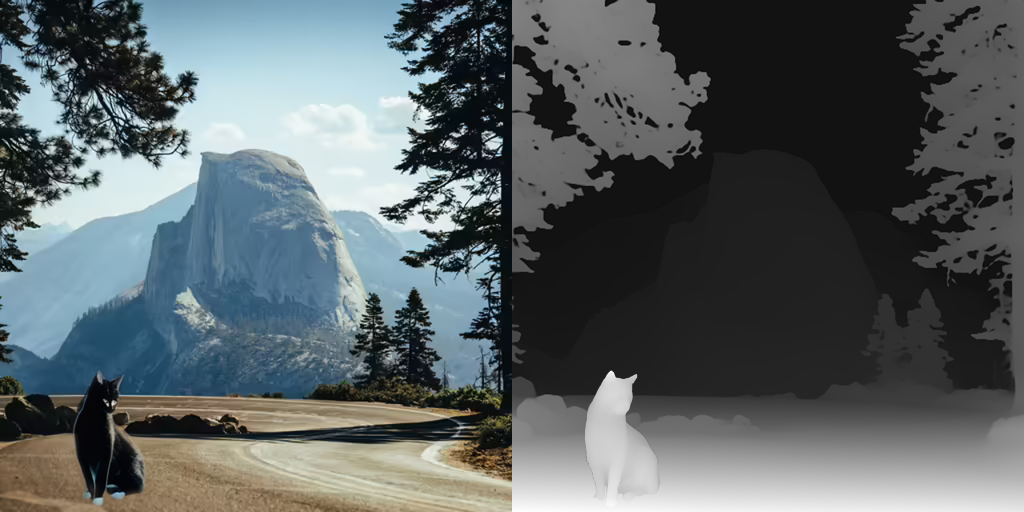

In [99]:
img = {"image": image, "mask": blended_mask}

new_image, controlnet_image = model(
        input_image=img,
        input_control_image=large_image,
        control_type="depth",
        prompt="white cat",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8,
        get_depth_map=False)

CombineImagesHorizontally(new_image, large_image)

  0%|          | 0/50 [00:00<?, ?it/s]

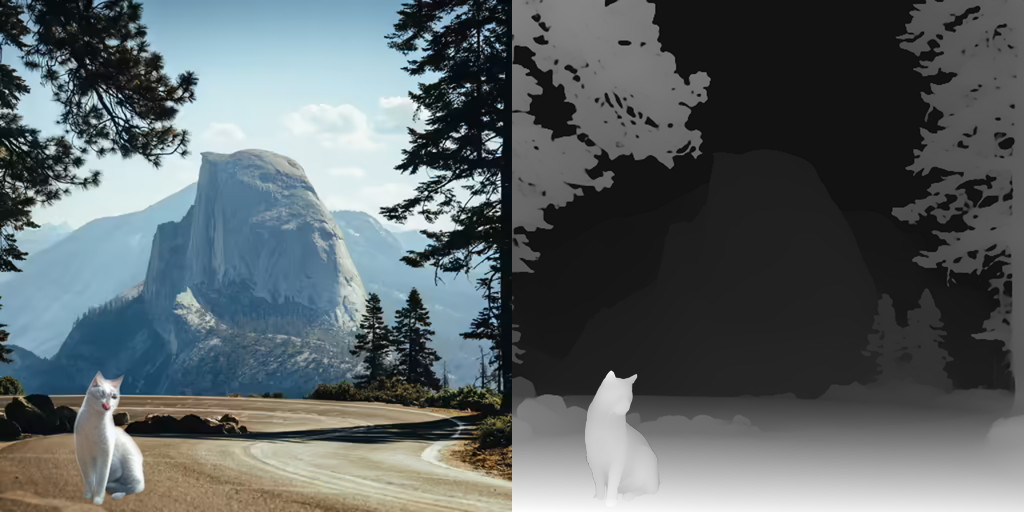

In [100]:
img = {"image": image, "mask": blended_mask}

new_image, controlnet_image = model(
        input_image=img,
        input_control_image=large_image,
        control_type="depth",
        prompt="white cat",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8,
        get_depth_map=False)

CombineImagesHorizontally(new_image, large_image)